# Simulador

Esse notebook realiza APENAS o treinamento do Simulador.

# Bibliotecas

In [ ]:
!pip install torch scikit-image

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import time
from tqdm import tqdm
from skimage.draw import polygon

# Dados de entrada:

Carregar a biblioteca contendo as simulações do CST, calcular a trasmitância e a fase em TE e TM e criar um dataframe.


Nanopilares Elipticos:

In [12]:
DEFAULT_HEIGHT = 600.0
DEFAULT_ANGLE = 0.0
IMG_SIZE = 64
MAX_DIM_NM = 520

def processar_pkl(caminho):
    """
    Função auxiliar para carregar, filtrar e processar um .pkl
    """
    if not os.path.exists(caminho):
        print(f"--- ERRO: Arquivo NÃO encontrado ---")
        print(f"Verifique o caminho: '{caminho}'")
        return None

    try:
        df_real = pd.read_pickle(caminho)
        print(f"Carregada: '{caminho}'. Forma inicial: {df_real.shape}")

        if 'S24_real' not in df_real.columns or 'S13_real' not in df_real.columns:
            raise KeyError("Colunas 'S24_real' ou 'S13_real' não encontradas.")

        df_real['S_complex_TM'] = df_real['S24_real'] + 1j * df_real['S24_imag']
        df_real['S_complex_TE'] = df_real['S13_real'] + 1j * df_real['S13_imag']

        df_filtrado_2D = df_real[
            (df_real['H'] == DEFAULT_HEIGHT) &
            (df_real['a'] == DEFAULT_ANGLE) &
            (df_real['L_x'] % 5 == 0) &
            (df_real['L_y'] % 5 == 0)
        ].copy()

        print(f"Filtrada para 2D. Nova forma: {df_filtrado_2D.shape}")

        if df_filtrado_2D.shape[0] == 0:
            raise ValueError("Filtragem resultou em 0 átomos.")

        df_filtrado_2D['Transmitancia_x'] = np.abs(df_filtrado_2D['S_complex_TM'])
        df_filtrado_2D['Fase_x'] = np.angle(df_filtrado_2D['S_complex_TM'])
        df_filtrado_2D['Transmitancia_y'] = np.abs(df_filtrado_2D['S_complex_TE'])
        df_filtrado_2D['Fase_y'] = np.angle(df_filtrado_2D['S_complex_TE'])

        return df_filtrado_2D

    except Exception as e:
        print(f"Ocorreu um erro ao processar '{caminho}': {e}")
        return None

# --- Função 2: Processamento de Elipses (MODIFICADA) ---
def processar_elipses_pkl(caminho):
    """
    Função auxiliar para carregar e processar 7lib.pkl,
    MANTENDO AS ROTAÇÕES (coluna 'a').
    """
    if not os.path.exists(caminho):
        print(f"--- ERRO: Arquivo NÃO encontrado ---")
        return None
    try:
        df_real = pd.read_pickle(caminho)
        print(f"Carregada: '{caminho}'. Forma inicial: {df_real.shape}")

        if 'S24_real' not in df_real.columns or 'S13_real' not in df_real.columns:
            raise KeyError("Colunas 'S24_real' ou 'S13_real' não encontradas.")

        df_real['S_complex_TM'] = df_real['S24_real'] + 1j * df_real['S24_imag']
        df_real['S_complex_TE'] = df_real['S13_real'] + 1j * df_real['S13_imag']

        # FILTRAGEM MODIFICADA: Remove o filtro 'a == 0'
        df_filtrado_2D = df_real[
            (df_real['H'] == DEFAULT_HEIGHT) &
            # (df_real['a'] == DEFAULT_ANGLE) & <-- LINHA REMOVIDA
            (df_real['L_x'] % 5 == 0) &
            (df_real['L_y'] % 5 == 0)
        ].copy()

        print(f"Filtrada para 2D (H=600). Nova forma: {df_filtrado_2D.shape}")

        if df_filtrado_2D.shape[0] == 0:
            raise ValueError("Filtragem resultou em 0 átomos.")

        df_filtrado_2D['Transmitancia_x'] = np.abs(df_filtrado_2D['S_complex_TM'])
        df_filtrado_2D['Fase_x'] = np.angle(df_filtrado_2D['S_complex_TM'])
        df_filtrado_2D['Transmitancia_y'] = np.abs(df_filtrado_2D['S_complex_TE'])
        df_filtrado_2D['Fase_y'] = np.angle(df_filtrado_2D['S_complex_TE'])
        return df_filtrado_2D
    except Exception as e:
        print(f"Ocorreu um erro ao processar '{caminho}': {e}")
        return None

# --- Função 3: Processamento de Polígonos (NOVA) ---
def processar_poligonos_pkl(caminho):
    """
    Função adaptada para carregar os dados de POLÍGONOS.
    Ela filtra H=600, mas NÃO filtra a rotação 'a'.
    """
    if not os.path.exists(caminho):
        print(f"--- ERRO: Arquivo NÃO encontrado ---")
        return None
    try:
        df_real = pd.read_pickle(caminho)
        print(f"Carregada: '{caminho}'. Forma inicial: {df_real.shape}")

        if 'S24_real' not in df_real.columns or 'S13_real' not in df_real.columns:
            raise KeyError("Colunas 'S24_real' ou 'S13_real' não encontradas.")

        df_real['S_complex_TM'] = df_real['S24_real'] + 1j * df_real['S24_imag']
        df_real['S_complex_TE'] = df_real['S13_real'] + 1j * df_real['S13_imag']

        # FILTRAGEM NOVA: Apenas 'H'
        df_filtrado_2D = df_real[
            (df_real['H'] == DEFAULT_HEIGHT)
        ].copy()

        print(f"Filtrada para 2D (H=600). Nova forma: {df_filtrado_2D.shape}")

        if df_filtrado_2D.shape[0] == 0:
            raise ValueError("Filtragem resultou em 0 átomos.")

        df_filtrado_2D['Transmitancia_x'] = np.abs(df_filtrado_2D['S_complex_TM'])
        df_filtrado_2D['Fase_x'] = np.angle(df_filtrado_2D['S_complex_TM'])
        df_filtrado_2D['Transmitancia_y'] = np.abs(df_filtrado_2D['S_complex_TE'])
        df_filtrado_2D['Fase_y'] = np.angle(df_filtrado_2D['S_complex_TE'])
        return df_filtrado_2D
    except Exception as e:
        print(f"Ocorreu um erro ao processar '{caminho}': {e}")
        return None

Transformar o meta átomo em uma imagem 64x64 para que a rede consiga tratá-lo.

In [13]:
IMG_SIZE = 64 # 64x64 pixels
MAX_DIM_NM = 520 # O tamanho físico total da célula unitária

# Função de Desenho 1: ELIPSE
def draw_meta_atom_ellipse(L_x_nm, L_y_nm, a_deg):
    """
    Desenha um meta-átomo de ELIPSE ROTACIONADA como um array numpy binário.
    """
    scale_factor = IMG_SIZE / MAX_DIM_NM
    a_px = L_x_nm * scale_factor # Raio semi-eixo X
    b_px = L_y_nm * scale_factor # Raio semi-eixo Y

    if a_px == 0 or b_px == 0:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

    x = np.arange(0, IMG_SIZE)
    y = np.arange(0, IMG_SIZE)
    xx, yy = np.meshgrid(x, y)
    center = (IMG_SIZE - 1) / 2.0

    # --- Início da Rotação ---
    a_rad = np.deg2rad(a_deg)
    cos_a = np.cos(a_rad)
    sin_a = np.sin(a_rad)

    # Coordenadas centradas
    x_c = xx - center
    y_c = yy - center

    # Aplicar matriz de rotação inversa às coordenadas
    # (x' = x*cos + y*sin, y' = -x*sin + y*cos)
    x_rot = x_c * cos_a + y_c * sin_a
    y_rot = -x_c * sin_a + y_c * cos_a

    # Equação da elipse com coordenadas rotacionadas
    term_x = (x_rot / a_px) ** 2
    term_y = (y_rot / b_px) ** 2
    mask = (term_x + term_y) <= 1
    # --- Fim da Rotação ---

    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    img[mask] = 1.0
    return img

# Função de Desenho 2: RETÂNGULO
def draw_meta_atom_rectangle(X_nm, Y_nm):
    """
    Desenha um meta-átomo de RETÂNGULO como um array numpy binário.
    """
    scale_factor = IMG_SIZE / MAX_DIM_NM
    width_px = X_nm * scale_factor
    height_px = Y_nm * scale_factor

    if width_px == 0 or height_px == 0:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

    x = np.arange(0, IMG_SIZE)
    y = np.arange(0, IMG_SIZE)
    xx, yy = np.meshgrid(x, y)
    center = (IMG_SIZE - 1) / 2.0

    x_min = center - width_px / 2.0
    x_max = center + width_px / 2.0
    y_min = center - height_px / 2.0
    y_max = center + height_px / 2.0

    mask_x = (xx >= x_min) & (xx <= x_max)
    mask_y = (yy >= y_min) & (yy <= y_max)
    mask = mask_x & mask_y

    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    img[mask] = 1.0
    return img

def draw_meta_atom_polygon(b, a_deg, R_nm):
    """
    Desenha um meta-átomo de POLÍGONO regular como um array numpy binário.
    - b: Número de lados/vértices (ex: 3, 4, 5...)
    - a_deg: Ângulo de rotação em graus (ex: 0, 22.5, 45)
    - R_nm: Raio do círculo circunscrito (em nanômetros)
    """
    scale_factor = IMG_SIZE / MAX_DIM_NM

    R_px = R_nm * scale_factor
    center = (IMG_SIZE - 1) / 2.0
    a_rad = np.deg2rad(a_deg)

    vert_x = []
    vert_y = []

    for i in range(b):
        angle = (2 * np.pi * i / b) + a_rad
        vx = center + R_px * np.cos(angle)
        vy = center + R_px * np.sin(angle)
        vert_x.append(vx)
        vert_y.append(vy)

    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

    # skimage.draw.polygon calcula os pixels DENTRO dos vértices
    # A ordem é (linha, coluna) ou (y, x)
    rr, cc = polygon(vert_y, vert_x)

    # Garante que os índices estão dentro dos limites da imagem
    rr = np.clip(rr, 0, IMG_SIZE - 1)
    cc = np.clip(cc, 0, IMG_SIZE - 1)

    img[rr, cc] = 1.0
    return img

# Verificação 1: ELIPSES ROTACIONADAS (NOVA)
def verificar_desenhos_elipses(df_para_teste):
    """
    Plota 9 amostras aleatórias das elipses rotacionadas.
    """
    print("Verificando 9 amostras de desenhos de elipses...")
    plt.figure(figsize=(10, 10))

    # Pega 9 amostras aleatórias
    amostras = df_para_teste.sample(min(9, len(df_para_teste)))

    for i, (index, row) in enumerate(amostras.iterrows()):
        Lx = row['L_x']
        Ly = row['L_y']
        a_val = row['a'] # A coluna original de rotação

        # Chama a função de desenho MODIFICADA
        img = draw_meta_atom_ellipse(Lx, Ly, a_val)

        plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Lx={Lx}nm, Ly={Ly}nm, a={a_val}°')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- NOVA Função de Verificação ---
def verificar_desenhos_poligonos(df_para_teste):
    """
    Plota 9 amostras aleatórias dos polígonos para verificação visual.
    """
    print("Verificando 9 amostras de desenhos de polígonos...")
    plt.figure(figsize=(10, 10))

    amostras = df_para_teste.sample(min(9, len(df_para_teste)))

    for i, (index, row) in enumerate(amostras.iterrows()):
        # Pega os dados da linha para desenhar
        b_val = int(row['b'])
        a_val = row['a_deg']
        R_val = row['R_nm']

        img = draw_meta_atom_polygon(b_val, a_val, R_val)

        plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'b={b_val}, a={a_val}°, R={R_val:.0f}nm')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Processando Biblioteca de Elipses...
Carregada: '/content/7lib.pkl'. Forma inicial: (5507, 54)
Filtrada para 2D (H=600). Nova forma: (2979, 56)
Rodando verificação visual das elipses...
Verificando 9 amostras de desenhos de elipses...


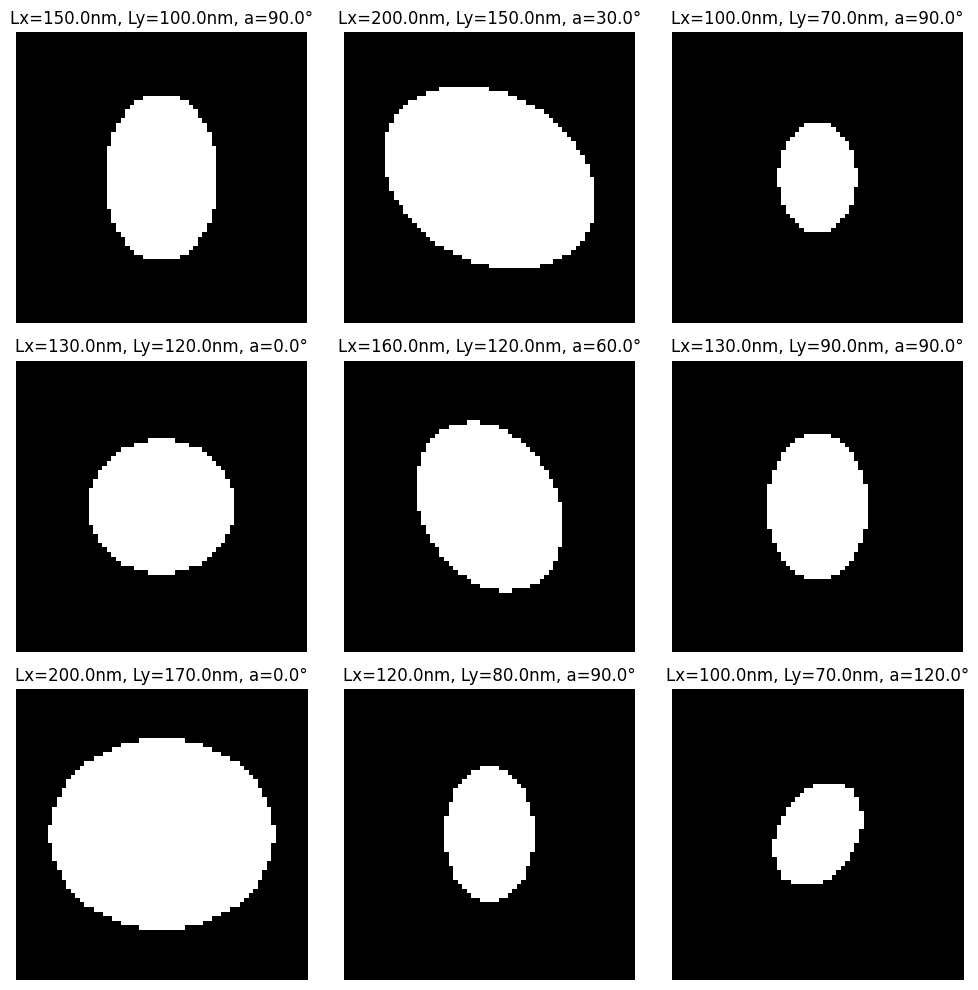

Gerando imagens de elipse...
2979 imagens de elipse adicionadas.

--- PREPARAÇÃO DE DADOS CONCLUÍDA ---
Total de 2979 imagens geradas.
Total de 2979 alvos combinados.

Plotando 50 amostras aleatórias do dataset real...


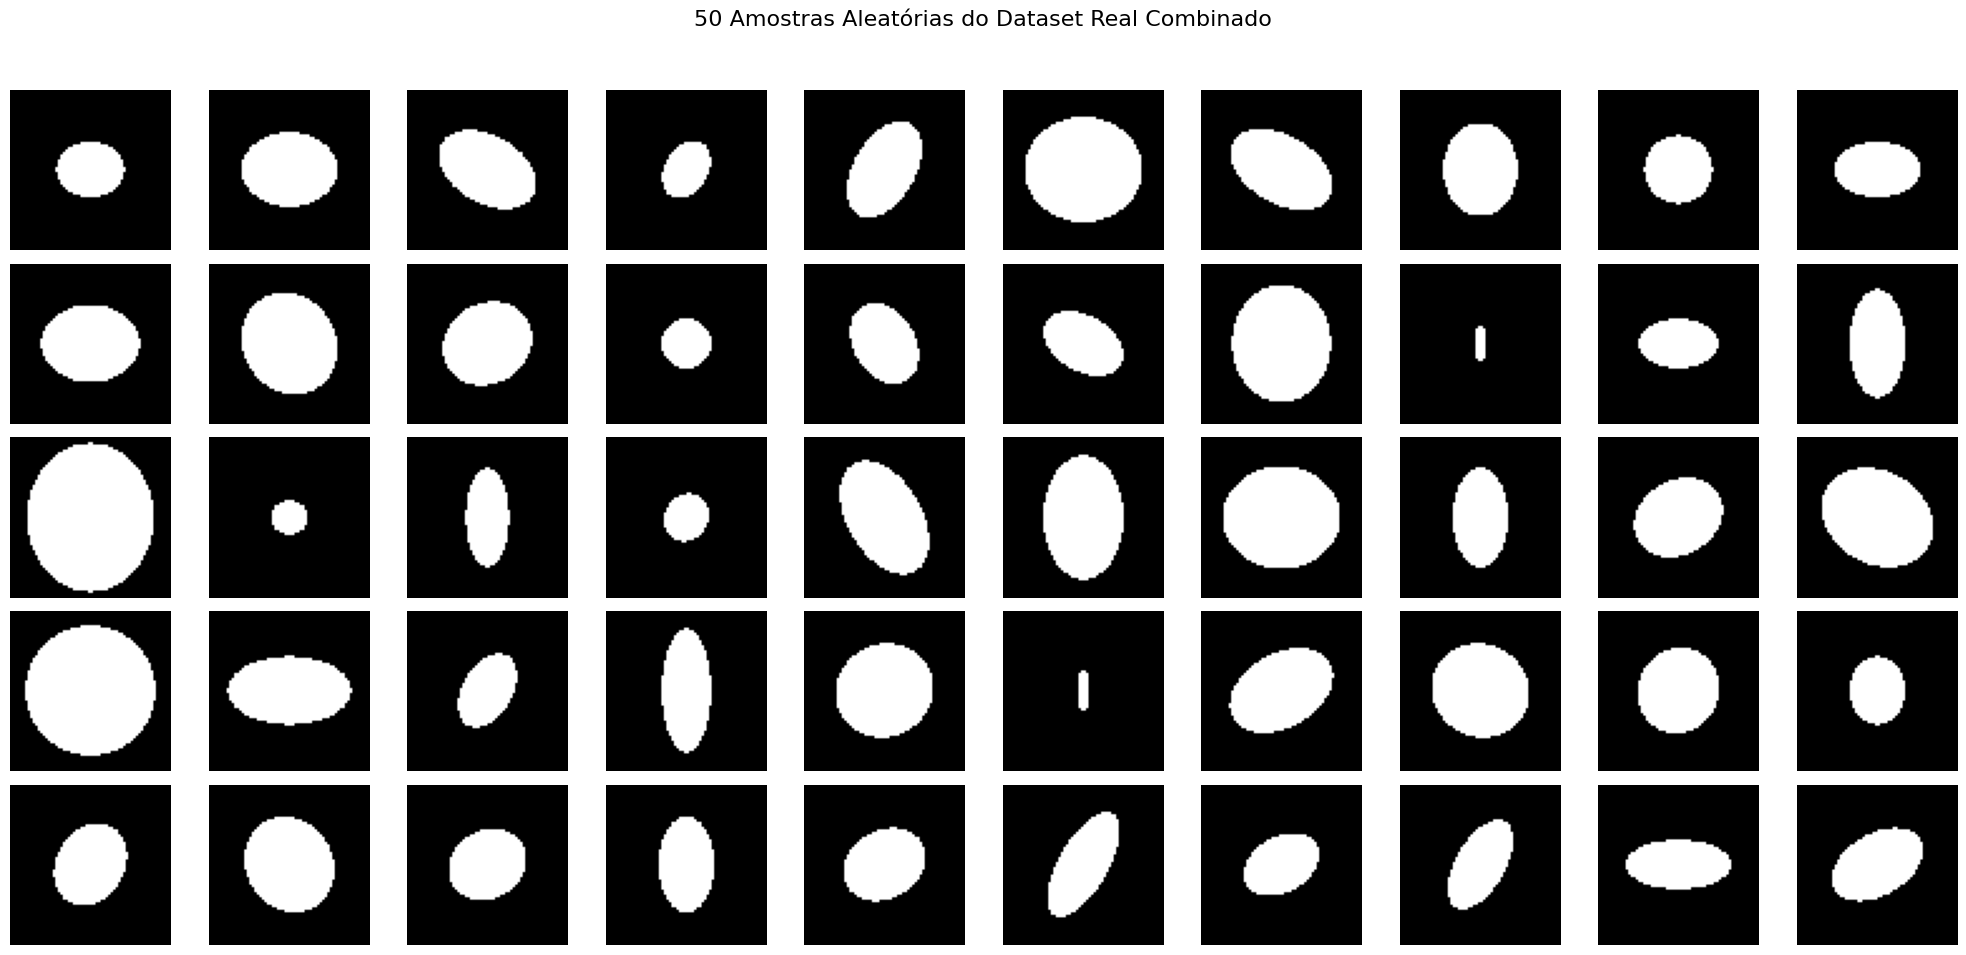

In [22]:
# --- CAMINHOS PARA OS ARQUIVOS ---
caminho_elipse_pkl = "/content/7lib.pkl"
# caminho_ret_pkl = "/content/RETlib.pkl"
# caminho_poligonos_pkl = "/content/Novas_Geometrias.pkl"

# --- 1. Processar Elipses (com rotação) ---
print("Processando Biblioteca de Elipses...")
df_ellipses = processar_elipses_pkl(caminho_elipse_pkl) # Usa a função NOVA
if df_ellipses is not None:
    # --- VERIFICAÇÃO VISUAL (ELIPSES) ---
    print("Rodando verificação visual das elipses...")
    verificar_desenhos_elipses(df_ellipses)

# # --- 2. Processar Retângulos (sem rotação) ---
# print("\nProcessando Biblioteca de Retângulos...")
# df_rects = processar_pkl(caminho_ret_pkl) # Usa a função ANTIGA (com filtro a=0)
# if df_rects is not None:
#      df_rects = df_rects.rename(columns={'L_x': 'X', 'L_y': 'Y'})
#      print("Colunas 'L_x'/'L_y' de RETlib renomeadas para 'X'/'Y'.")

# --- 3. Processar Polígonos (com rotação) ---
# print("\nProcessando Biblioteca de Polígonos...")
# df_polygons = processar_poligonos_pkl(caminho_poligonos_pkl) # Usa a função NOVA

# if df_polygons is not None:
#     try:
#         # Apenas renomeia as colunas (a coluna 'a' já está em graus)
#         df_polygons = df_polygons.rename(columns={'a': 'a_deg', 'R_l': 'R_nm'})
#         print(f"Colunas de polígono 'a' e 'R_l' renomeadas para 'a_deg' e 'R_nm'.")

#         # --- VERIFICAÇÃO VISUAL (POLÍGONOS) ---
#         print("Rodando verificação visual dos polígonos...")
#         verificar_desenhos_poligonos(df_polygons)

#     except KeyError as e:
#         print(f"--- ERRO: Coluna não encontrada no 'Novas_Geometrias.pkl' ---")
#         print(f"Verifique os nomes 'a' ou 'R_l'. Erro: {e}")
#         df_polygons = None
# else:
#     print("--- AVISO: DataFrame de polígonos não foi carregado. ---")


# --- 4. Juntar todos os dados para o Treinamento ---
all_images = []
all_targets_list = []
target_cols = ['S24_real', 'S24_imag', 'S13_real', 'S13_imag']

# 1. Adicionar Elipses
if df_ellipses is not None:
    print("Gerando imagens de elipse...")
    for index, row in df_ellipses.iterrows():
        # Passa L_x, L_y, e a rotação 'a'
        all_images.append(draw_meta_atom_ellipse(row['L_x'], row['L_y'], row['a']))
    all_targets_list.append(df_ellipses[target_cols].values)
    print(f"{len(df_ellipses)} imagens de elipse adicionadas.")

# # 2. Adicionar Retângulos
# if df_rects is not None:
#     print("Gerando imagens de retângulo...")
#     for index, row in df_rects.iterrows():
#         all_images.append(draw_meta_atom_rectangle(row['X'], row['Y']))
#     all_targets_list.append(df_rects[target_cols].values)
#     print(f"{len(df_rects)} imagens de retângulo adicionadas.")

# # 3. Adicionar Polígonos
# if df_polygons is not None:
#     print("Gerando imagens de polígono...")
#     for index, row in df_polygons.iterrows():
#         img = draw_meta_atom_polygon(int(row['b']), row['a_deg'], row['R_nm'])
#         all_images.append(img)
#     all_targets_list.append(df_polygons[target_cols].values)
#     print(f"{len(df_polygons)} imagens de polígono adicionadas.")

# # --- 5. Concatenação Final ---
# if all_targets_list:
#     targets = np.concatenate(all_targets_list, axis=0).astype(np.float32)
#     print(f"\n--- PREPARAÇÃO DE DADOS CONCLUÍDA ---")
#     print(f"Total de {len(all_images)} imagens geradas.")
#     print(f"Total de {len(targets)} alvos combinados.")

#     # Limpa a memória
#     del all_targets_list
#     del df_ellipses, df_rects, df_polygons

# else:
#     print("\n--- ERRO ---")
#     print("Nenhum DataFrame foi carregado com sucesso. Verifique os caminhos e erros.")
# --- 5. Concatenação Final ---
if all_targets_list:
    targets = np.concatenate(all_targets_list, axis=0).astype(np.float32)
    print(f"\n--- PREPARAÇÃO DE DADOS CONCLUÍDA ---")
    print(f"Total de {len(all_images)} imagens geradas.")
    print(f"Total de {len(targets)} alvos combinados.")


    # --- INÍCIO DO NOVO CÓDIGO DE VISUALIZAÇÃO ---
    import random
    import matplotlib.pyplot as plt

    print("\nPlotando 50 amostras aleatórias do dataset real...")

    N_SAMPLES_REAL = 50
    num_to_plot = min(N_SAMPLES_REAL, len(all_images))

    # Seleciona 50 índices aleatórios da lista de imagens
    random_indices = random.sample(range(len(all_images)), num_to_plot)

    plt.figure(figsize=(20, 10)) # 5 linhas, 10 colunas
    plt.suptitle("50 Amostras Aleatórias do Dataset Real Combinado", fontsize=16)

    for i, idx in enumerate(random_indices):
        img_np = all_images[idx] # Pega a imagem da lista

        plt.subplot(5, 10, i + 1)
        plt.imshow(img_np, cmap='gray')
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    # --- FIM DO NOVO CÓDIGO DE VISUALIZAÇÃO ---


    # Limpa a memória (código original)
    del all_targets_list
    # del df_ellipses, df_rects, df_polygons

else:
    print("\n--- ERRO ---")
    print("Nenhum DataFrame foi carregado com sucesso. Verifique os caminhos e erros.")

Fazer um adaptador de dados para o PyTorch. Ele pega suas listas de dados brutos e os "empacota" um por um, convertendo-os no formato exato que o PyTorch entende (Tensores) para que possam ser usados no treinamento do modelo.

In [23]:
class MetaAtomDataset(Dataset):
    """
    Dataset que carrega imagens de meta-átomos e seus alvos ópticos.
    """

    def __init__(self, images_list, targets_array, transform=None):

        self.images = images_list
        self.targets = targets_array
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        image = np.expand_dims(image, axis=0)

        # Converte para tensor
        image = torch.from_numpy(image)
        target = torch.from_numpy(target)

        if self.transform:
            image = self.transform(image)

        return image, target

Preparar os dados para o treinamento. Agrupa todos os dados brutos em um único dataset, divide em dois conjuntos: 80% para treino e 20% para validação.

Cria dois "alimentadores" (DataLoader) que entregam esses dados em lotes (batches) para a rede neural, um para treinar (train_loader) e outro para validar (val_loader).

In [24]:
dataset = MetaAtomDataset(all_images, targets, transform=None)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Construir o simulador (ResNet):

Definir o bloco de construção fundamental de uma ResNet, Bloco Residual ou ResBlock.

In [25]:
class ResBlock(nn.Module):
    """
    Define um bloco ResNet básico
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.main_path = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut_path = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut_path = nn.Sequential(

                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.main_path(x) + self.shortcut_path(x)
        out = F.relu(out)
        return out

Define a arquitetura completa da sua rede neural Simulator, baseada na ResNet.

In [26]:
# N_OUTPUTS é quantos valores se quer prever
N_OUTPUTS = 4

class ResNetSimulator(nn.Module):
    """
    Implementação do Simulator baseado em ResNet.
    """
    def __init__(self, in_channels=1, n_outputs=N_OUTPUTS):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = ResBlock(64, 64, stride=1)

        self.layer2 = ResBlock(64, 128, stride=2)

        self.layer3 = ResBlock(128, 256, stride=2)

        self.layer4 = ResBlock(256, 256, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))

        self.head = nn.Sequential(
            nn.Linear(256 * 2 * 2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.head(out)
        return out

Executar o processo de treinamento e validação. Ao fim, salva o modelo treinado.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNetSimulator(in_channels=1, n_outputs=N_OUTPUTS).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)
epochs = 100

print("Iniciando treinamento do Simulator...")
start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()

    model.train()
    total_train_loss = 0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            predictions = model(images)
            loss = criterion(predictions, targets)
            total_val_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Tempo: {epoch_duration:.2f}s")

end_time = time.time()
total_time = end_time - start_time
minutos = total_time / 60

print(f"\nTreinamento concluído em {total_time:.2f} segundos ({minutos:.2f} minutos).")


Iniciando treinamento do Simulator...
Epoch [1/100], Train Loss: 0.1534, Val Loss: 0.0944, Tempo: 2.86s
Epoch [2/100], Train Loss: 0.0619, Val Loss: 0.0546, Tempo: 1.16s
Epoch [3/100], Train Loss: 0.0412, Val Loss: 0.0505, Tempo: 1.18s
Epoch [4/100], Train Loss: 0.0343, Val Loss: 0.0410, Tempo: 1.17s
Epoch [5/100], Train Loss: 0.0290, Val Loss: 0.0430, Tempo: 1.17s
Epoch [6/100], Train Loss: 0.0273, Val Loss: 0.0327, Tempo: 1.17s
Epoch [7/100], Train Loss: 0.0235, Val Loss: 0.0304, Tempo: 1.19s
Epoch [8/100], Train Loss: 0.0217, Val Loss: 0.0289, Tempo: 1.16s
Epoch [9/100], Train Loss: 0.0217, Val Loss: 0.0304, Tempo: 1.16s
Epoch [10/100], Train Loss: 0.0203, Val Loss: 0.0311, Tempo: 1.17s
Epoch [11/100], Train Loss: 0.0204, Val Loss: 0.0296, Tempo: 1.17s
Epoch [12/100], Train Loss: 0.0207, Val Loss: 0.0322, Tempo: 1.16s
Epoch [13/100], Train Loss: 0.0204, Val Loss: 0.0304, Tempo: 1.16s
Epoch [14/100], Train Loss: 0.0196, Val Loss: 0.0300, Tempo: 1.17s
Epoch [15/100], Train Loss: 0.018

In [ ]:
SIMULATOR_PATH = "simulador_Elipticos_teste_2.pth"
torch.save(model.state_dict(), SIMULATOR_PATH)
print(f"Modelo Simulator salvo em {SIMULATOR_PATH}")

Modelo Simulator salvo em simulador_NG_teste_1.pth


# Validação do Modelo Treinado

Com o modelo treinado, podemos pedir para que ele encontre a resposta de uma meta-átomo novo, e verificar se corresponde com a realidade:

Modelo carregado com sucesso de /content/simulator_teste_2,.pth

Iniciando verificação de precisão...

--- Métricas de Performance (Transmitância/Fase) ---

Resultados para: Transmitancia X
  MAE (Erro Absoluto Médio): 0.706951
  RMSE (Raiz do Erro Quad.): 0.886669
  R² (Coef. de Determinação): -1.803738 (ou -180.37%)

Resultados para: Transmitancia Y
  MAE (Erro Absoluto Médio): 1.332630
  RMSE (Raiz do Erro Quad.): 1.441037
  R² (Coef. de Determinação): -6.084940 (ou -608.49%)

Resultados para: Fase X (rad)
  MAE (Erro Absoluto Médio): 1.254177
  RMSE (Raiz do Erro Quad.): 1.428909
  R² (Coef. de Determinação): -6.096079 (ou -609.61%)

Resultados para: Fase Y (rad)
  MAE (Erro Absoluto Médio): 0.628411
  RMSE (Raiz do Erro Quad.): 0.866946
  R² (Coef. de Determinação): -1.580308 (ou -158.03%)

Gerando gráficos de dispersão da validação...


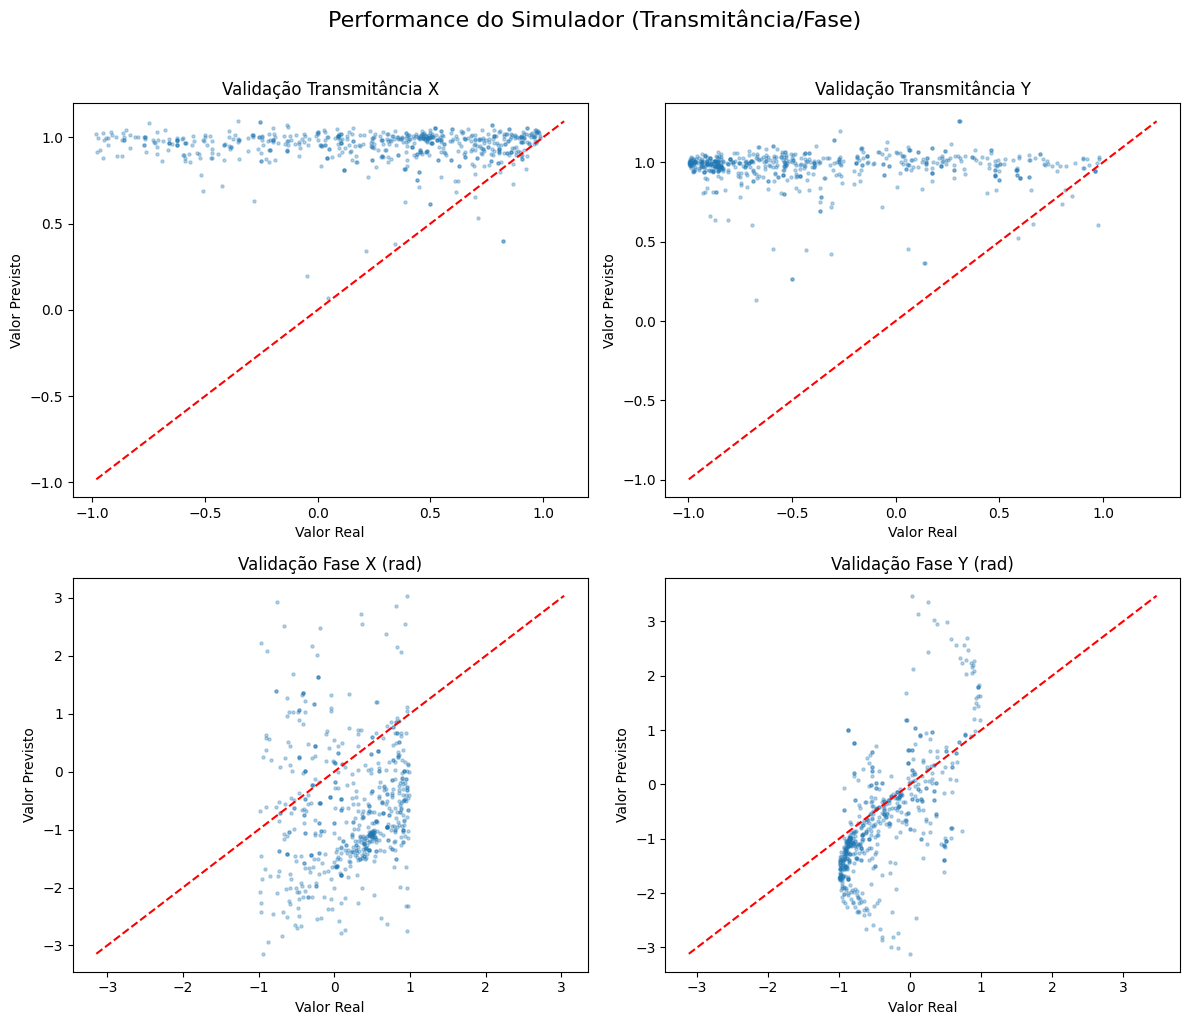


--- Simulação para L_x = 100, L_y = 100, a = 0 ---

Tensor de Saída Bruta (T/Fase): [[ 0.982177   1.0047379 -2.159238  -2.021464 ]]
           Resultados da Simulação                
 L_x: 100.0 nm, L_y: 100.0 nm, a: 0.0 deg
 Transmitancia_x Prevista: 0.9822
 Transmitancia_y Prevista: 1.0047
 Fase_x Prevista: -2.159238 rad
 Fase_y Prevista: -2.021464 rad
 Buscando valores reais no DataFrame para (100.0, 100.0, 0.0)...
           Valores Reais (do DataFrame)           
 Transmitancia_x Real: 0.9981
 Transmitancia_y Real: 0.9983
 Fase_x Real: -2.158551 rad
 Fase_y Real: -2.159303 rad


In [27]:
# --- Imports necessários para métricas e o modelo ---
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from numpy import sqrt

# --- 1. Definição do Ambiente e Arquitetura ---
# (Necessário para instanciar o modelo antes de carregar os pesos)

# Definir o device (da sua célula de treino)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Definição do Bloco Residual (da sua célula)
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut_path = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut_path = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.main_path(x) + self.shortcut_path(x)
        out = F.relu(out)
        return out

# Definição do Simulador (da sua célula)
N_OUTPUTS = 4
class ResNetSimulator(nn.Module):
    def __init__(self, in_channels=1, n_outputs=N_OUTPUTS):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = ResBlock(64, 64, stride=1)
        self.layer2 = ResBlock(64, 128, stride=2)
        self.layer3 = ResBlock(128, 256, stride=2)
        self.layer4 = ResBlock(256, 256, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.head = nn.Sequential(
            nn.Linear(256 * 2 * 2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.head(out)
        return out

# --- 2. Carregar o Modelo Treinado ---
# (Caminho do seu modelo salvo)
SIMULATOR_PATH = "/content/simulator_teste_2,.pth"

# Instanciar a arquitetura
model = ResNetSimulator(in_channels=1, n_outputs=N_OUTPUTS).to(device)

# Carregar os pesos treinados
try:
    model.load_state_dict(torch.load(SIMULATOR_PATH, map_location=device))
    print(f"Modelo carregado com sucesso de {SIMULATOR_PATH}")
except Exception as e:
    print(f"ERRO AO CARREGAR O MODELO: {e}")
    print("Verifique se o caminho do SIMULATOR_PATH está correto.")

# --- 3. Verificação de Precisão (com dados de validação) ---
print("\nIniciando verificação de precisão...")

# Garantir que o modelo esteja em modo de avaliação
model.eval()

all_predictions = []
all_ground_truth = []

# Obter predições (T_x, T_y, F_x, F_y) do val_loader
with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        predictions = model(images)
        all_predictions.append(predictions.cpu().numpy())
        all_ground_truth.append(targets.cpu().numpy())

# Concatenar todos os lotes
all_predictions = np.concatenate(all_predictions, axis=0)
all_ground_truth = np.concatenate(all_ground_truth, axis=0)

# --- 4. Calcular Métricas de Performance (T/F) ---
print("\n--- Métricas de Performance (Transmitância/Fase) ---")

# Labels baseados na ordem do seu notebook original
labels_tf = ['Transmitancia X', 'Transmitancia Y', 'Fase X (rad)', 'Fase Y (rad)']

# Loop por T_x, T_y, F_x, F_y
for i in range(4):
    y_true = all_ground_truth[:, i]
    y_pred = all_predictions[:, i]

    # Calcular as métricas
    mae_tf = mean_absolute_error(y_true, y_pred)
    mse_tf = mean_squared_error(y_true, y_pred)
    rmse_tf = sqrt(mse_tf)
    r2_tf = r2_score(y_true, y_pred)

    print(f"\nResultados para: {labels_tf[i]}")
    print(f"  MAE (Erro Absoluto Médio): {mae_tf:.6f}")
    print(f"  RMSE (Raiz do Erro Quad.): {rmse_tf:.6f}")
    print(f"  R² (Coef. de Determinação): {r2_tf:.6f} (ou {r2_tf*100:.2f}%)")

print("\n" + "="*50)


# --- 5. Plotar Gráficos de Dispersão ---
print("Gerando gráficos de dispersão da validação...")
plt.figure(figsize=(12, 10))
plt.suptitle("Performance do Simulador (Transmitância/Fase)", fontsize=16, y=1.02)

# Ordem dos alvos: 0=T_x, 1=T_y, 2=F_x, 3=F_y
plt.subplot(2, 2, 1)
plt.scatter(all_ground_truth[:, 0], all_predictions[:, 0], alpha=0.3, s=5)
lims_tx = [min(all_ground_truth[:, 0].min(), all_predictions[:, 0].min()), max(all_ground_truth[:, 0].max(), all_predictions[:, 0].max())]
plt.plot(lims_tx, lims_tx, 'r--', label='Perfeita')
plt.title("Validação Transmitância X")
plt.xlabel("Valor Real"); plt.ylabel("Valor Previsto")

plt.subplot(2, 2, 2)
plt.scatter(all_ground_truth[:, 1], all_predictions[:, 1], alpha=0.3, s=5)
lims_ty = [min(all_ground_truth[:, 1].min(), all_predictions[:, 1].min()), max(all_ground_truth[:, 1].max(), all_predictions[:, 1].max())]
plt.plot(lims_ty, lims_ty, 'r--', label='Perfeita')
plt.title("Validação Transmitância Y")
plt.xlabel("Valor Real"); plt.ylabel("Valor Previsto")

plt.subplot(2, 2, 3)
plt.scatter(all_ground_truth[:, 2], all_predictions[:, 2], alpha=0.3, s=5)
lims_fx = [min(all_ground_truth[:, 2].min(), all_predictions[:, 2].min()), max(all_ground_truth[:, 2].max(), all_predictions[:, 2].max())]
plt.plot(lims_fx, lims_fx, 'r--', label='Perfeita')
plt.title("Validação Fase X (rad)")
plt.xlabel("Valor Real"); plt.ylabel("Valor Previsto")

plt.subplot(2, 2, 4)
plt.scatter(all_ground_truth[:, 3], all_predictions[:, 3], alpha=0.3, s=5)
lims_fy = [min(all_ground_truth[:, 3].min(), all_predictions[:, 3].min()), max(all_ground_truth[:, 3].max(), all_predictions[:, 3].max())]
plt.plot(lims_fy, lims_fy, 'r--', label='Perfeita')
plt.title("Validação Fase Y (rad)")
plt.xlabel("Valor Real"); plt.ylabel("Valor Previsto")

plt.tight_layout()
plt.show()


# --- 6. Simulação para Novos Valores (Teste de Ponto Único) ---
print("\n--- Simulação para L_x = 100, L_y = 100, a = 0 ---")

L_x_new_nm = 100.0
L_y_new_nm = 100.0
a_new_deg = 0.0 # Rotação de 0 graus para este teste

try:
    # 1. Gerar a imagem
    # (Assumindo que 'draw_meta_atom_ellipse' aceita rotação 'a')
    img_new = draw_meta_atom_ellipse(L_x_new_nm, L_y_new_nm, a_new_deg)

    # 2. Converter para o formato de tensor de batch (1, 1, 64, 64)
    input_tensor = torch.from_numpy(img_new).unsqueeze(0).unsqueeze(0).to(device)

    # 3. Fazer a predição
    with torch.no_grad():
        pred_new_tf = model(input_tensor) # Saída direta [T_x, T_y, F_x, F_y]

    # 4. Extrair valores
    predicted_transmitancia_x = pred_new_tf[0, 0].item()
    predicted_transmitancia_y = pred_new_tf[0, 1].item()
    predicted_fase_x = pred_new_tf[0, 2].item()
    predicted_fase_y = pred_new_tf[0, 3].item()

    print(f"\nTensor de Saída Bruta (T/Fase): {pred_new_tf.cpu().numpy()}")
    print("==================================================")
    print("           Resultados da Simulação                ")
    print("==================================================")
    print(f" L_x: {L_x_new_nm} nm, L_y: {L_y_new_nm} nm, a: {a_new_deg} deg")
    print(f" Transmitancia_x Prevista: {predicted_transmitancia_x:.4f}")
    print(f" Transmitancia_y Prevista: {predicted_transmitancia_y:.4f}")
    print(f" Fase_x Prevista: {predicted_fase_x:.6f} rad")
    print(f" Fase_y Prevista: {predicted_fase_y:.6f} rad")

    # 5. Comparar com o DataFrame original
    print("==================================================")
    print(f" Buscando valores reais no DataFrame para ({L_x_new_nm}, {L_y_new_nm}, {a_new_deg})...")

    # (Assumindo que 'df_ellipses' existe na memória)
    real_data = df_ellipses[
        (df_ellipses['L_x'] == L_x_new_nm) &
        (df_ellipses['L_y'] == L_y_new_nm) &
        (df_ellipses['a'] == a_new_deg)
    ]

    if not real_data.empty:
        print("           Valores Reais (do DataFrame)           ")
        print("==================================================")
        # As colunas de 'targets' no df_ellipses devem ser T_x, T_y, F_x, F_y
        print(f" Transmitancia_x Real: {real_data['Transmitancia_x'].values[0]:.4f}")
        print(f" Transmitancia_y Real: {real_data['Transmitancia_y'].values[0]:.4f}")
        print(f" Fase_x Real: {real_data['Fase_x'].values[0]:.6f} rad")
        print(f" Fase_y Real: {real_data['Fase_y'].values[0]:.6f} rad")
        print("==================================================")
    else:
        print(f" ...Ponto ({L_x_new_nm}, {L_y_new_nm}, {a_new_deg}) não encontrado no DataFrame.")
        print("==================================================")
except NameError as e:
    print(f"\nAVISO: Uma variável necessária não foi encontrada: {e}")
    print("Certifique-se de que 'val_loader', 'draw_meta_atom_ellipse' e 'df_ellipses' foram definidos em células anteriores.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


--- Verificação de Precisão (com dados de validação) ---

Erro Absoluto Médio (Saídas Brutas Re/Im):
 S24_real: 0.0634, S24_imag: 0.0632, S13_real: 0.078762, S13_imag: 0.071672
Gerando gráficos de dispersão da validação (Convertidos para T/Fase)...


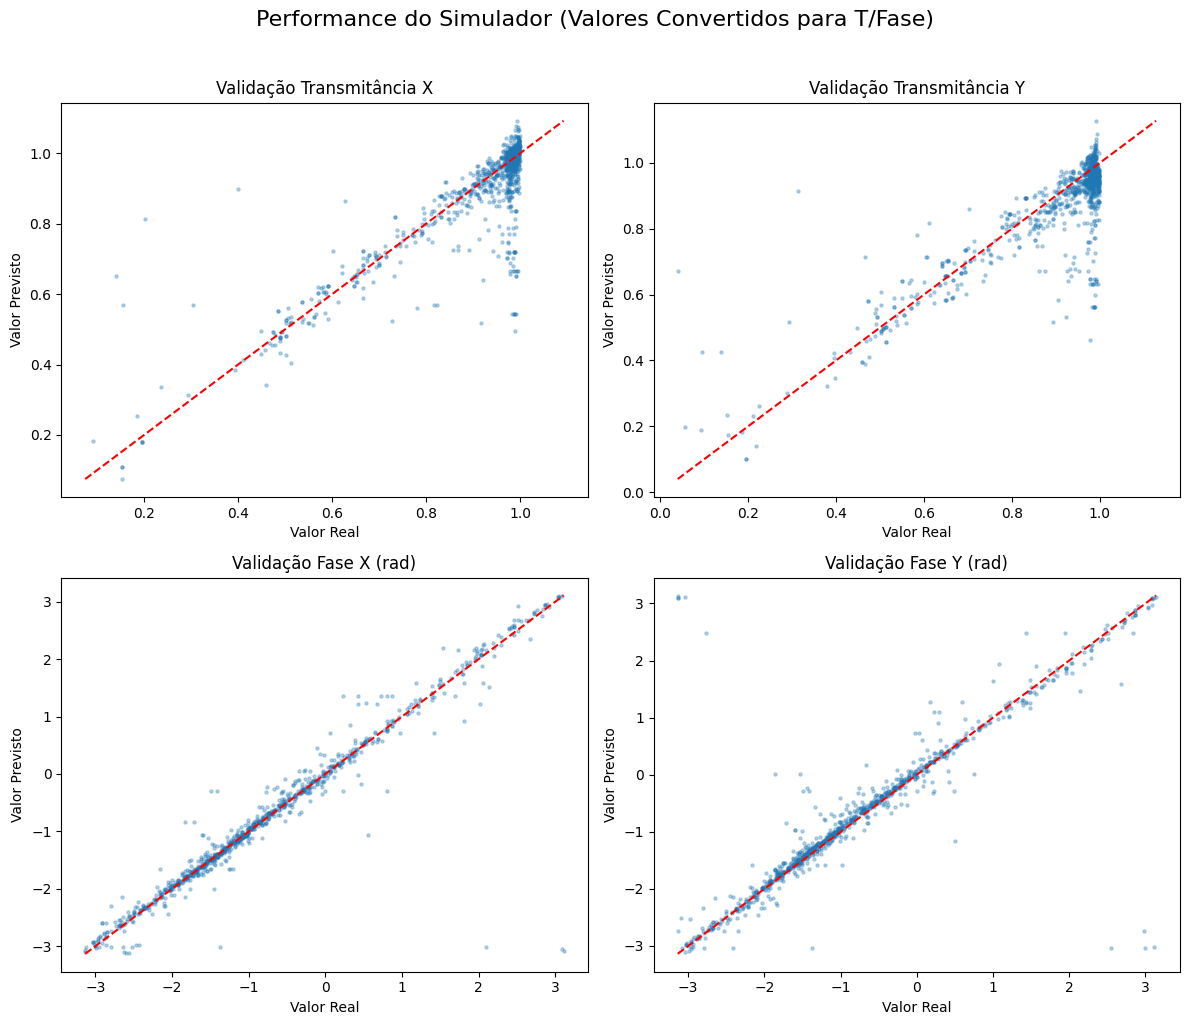


--- Simulação para L_x = 210, L_y = 100 ---

Tensor de Saída Bruta (Re/Im): [[-0.36427003 -0.9319479  -0.33167464 -0.90187603]]
         Resultados da Simulação (Convertidos)    
 L_x: 100.0 nm, L_y: 100.0 nm, a: 0.0 deg
 Transmitancia_x Prevista: 1.0006
 Transmitancia_y Prevista: 0.9609
 Fase_x Prevista: -1.943407 rad
 Fase_y Prevista: -1.923205 rad
 Buscando valores reais no DataFrame para (100.0, 100.0, 0.0)...

AVISO: O 'df_ellipses' não foi encontrado na memória.
Execute a célula de carregamento de dados novamente para fazer a comparação.


In [ ]:
print("\n--- Verificação de Precisão (com dados de validação) ---")

# Garantir que o modelo esteja em modo de avaliação
model.eval()

all_predictions_raw = []
all_ground_truth_raw = []

# 1. Obter predições brutas (Re/Im) do val_loader
with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        predictions = model(images)
        all_predictions_raw.append(predictions.cpu().numpy())
        all_ground_truth_raw.append(targets.cpu().numpy())

# Concatenar todos os lotes
all_predictions_raw = np.concatenate(all_predictions_raw, axis=0)
all_ground_truth_raw = np.concatenate(all_ground_truth_raw, axis=0)

# Calcular Erro Médio para as 4 saídas (Re/Im)
mae = np.mean(np.abs(all_predictions_raw - all_ground_truth_raw), axis=0)
print(f"\nErro Absoluto Médio (Saídas Brutas Re/Im):")
# Os rótulos agora estão corretos
print(f" S24_real: {mae[0]:.4f}, S24_imag: {mae[1]:.4f}, S13_real: {mae[2]:.6f}, S13_imag: {mae[3]:.6f}")


# 2. Converter Saídas Brutas (Re/Im) para Transmitância/Fase
def convert_to_tf(raw_data):
    # raw_data shape é (N, 4) com [S24_r, S24_i, S13_r, S13_i]

    # Calcular S_complex_TM (S24) e S_complex_TE (S13)
    s_tm = raw_data[:, 0] + 1j * raw_data[:, 1]
    s_te = raw_data[:, 2] + 1j * raw_data[:, 3]

    # Calcular Transmitância (Abs) e Fase (Angle)
    t_x = np.abs(s_tm)
    f_x = np.angle(s_tm)
    t_y = np.abs(s_te)
    f_y = np.angle(s_te)

    # Empilhar de volta no formato [T_x, T_y, F_x, F_y]
    return np.stack([t_x, t_y, f_x, f_y], axis=1)

all_predictions_tf = convert_to_tf(all_predictions_raw)
all_ground_truth_tf = convert_to_tf(all_ground_truth_raw)


# --- 3. Plotar Gráficos de Dispersão (Agora com T/F corretos) ---
print("Gerando gráficos de dispersão da validação (Convertidos para T/Fase)...")
plt.figure(figsize=(12, 10))
plt.suptitle("Performance do Simulador (Valores Convertidos para T/Fase)", fontsize=16, y=1.02)

# Ordem dos alvos convertidos: 0=T_x, 1=T_y, 2=F_x, 3=F_y
plt.subplot(2, 2, 1)
plt.scatter(all_ground_truth_tf[:, 0], all_predictions_tf[:, 0], alpha=0.3, s=5)
lims_tx = [min(all_ground_truth_tf[:, 0].min(), all_predictions_tf[:, 0].min()), max(all_ground_truth_tf[:, 0].max(), all_predictions_tf[:, 0].max())]
plt.plot(lims_tx, lims_tx, 'r--', label='Perfeita')
plt.title("Validação Transmitância X")
plt.xlabel("Valor Real"); plt.ylabel("Valor Previsto")

plt.subplot(2, 2, 2)
plt.scatter(all_ground_truth_tf[:, 1], all_predictions_tf[:, 1], alpha=0.3, s=5)
lims_ty = [min(all_ground_truth_tf[:, 1].min(), all_predictions_tf[:, 1].min()), max(all_ground_truth_tf[:, 1].max(), all_predictions_tf[:, 1].max())]
plt.plot(lims_ty, lims_ty, 'r--', label='Perfeita')
plt.title("Validação Transmitância Y")
plt.xlabel("Valor Real"); plt.ylabel("Valor Previsto")

plt.subplot(2, 2, 3)
plt.scatter(all_ground_truth_tf[:, 2], all_predictions_tf[:, 2], alpha=0.3, s=5)
lims_fx = [min(all_ground_truth_tf[:, 2].min(), all_predictions_tf[:, 2].min()), max(all_ground_truth_tf[:, 2].max(), all_predictions_tf[:, 2].max())]
plt.plot(lims_fx, lims_fx, 'r--', label='Perfeita')
plt.title("Validação Fase X (rad)")
plt.xlabel("Valor Real"); plt.ylabel("Valor Previsto")

plt.subplot(2, 2, 4)
plt.scatter(all_ground_truth_tf[:, 3], all_predictions_tf[:, 3], alpha=0.3, s=5)
lims_fy = [min(all_ground_truth_tf[:, 3].min(), all_predictions_tf[:, 3].min()), max(all_ground_truth_tf[:, 3].max(), all_predictions_tf[:, 3].max())]
plt.plot(lims_fy, lims_fy, 'r--', label='Perfeita')
plt.title("Validação Fase Y (rad)")
plt.xlabel("Valor Real"); plt.ylabel("Valor Previsto")

plt.tight_layout()
plt.show()


# --- 4. Simulação para Novos Valores (Teste de Ponto Único CORRIGIDO) ---
print("\n--- Simulação para L_x = 210, L_y = 100 ---")

L_x_new_nm = 100.0
L_y_new_nm = 100.0
a_new_deg = 0.0 # Rotação de 0 graus para este teste

# 1. Gerar a imagem (use a função de elipse que aceita rotação)
img_new = draw_meta_atom_ellipse(L_x_new_nm, L_y_new_nm, a_new_deg)

# 2. Converter para o formato de tensor de batch (1, 1, 64, 64)
input_tensor = torch.from_numpy(img_new).unsqueeze(0).unsqueeze(0).to(device)

# 3. Fazer a predição (o 'model' treinado já está na memória)
with torch.no_grad():
    pred_new_raw = model(input_tensor) # Saída bruta [S24_r, S24_i, S13_r, S13_i]

# 4. Extrair valores Re/Im
s24_r = pred_new_raw[0, 0].item()
s24_i = pred_new_raw[0, 1].item()
s13_r = pred_new_raw[0, 2].item()
s13_i = pred_new_raw[0, 3].item()

# 5. Converter para Transmitância e Fase
s_tm_pred = s24_r + 1j * s24_i
s_te_pred = s13_r + 1j * s13_i

predicted_transmitancia_x = np.abs(s_tm_pred)
predicted_fase_x = np.angle(s_tm_pred)
predicted_transmitancia_y = np.abs(s_te_pred)
predicted_fase_y = np.angle(s_te_pred)

print(f"\nTensor de Saída Bruta (Re/Im): {pred_new_raw.cpu().numpy()}")
print("==================================================")
print("         Resultados da Simulação (Convertidos)    ")
print("==================================================")
print(f" L_x: {L_x_new_nm} nm, L_y: {L_y_new_nm} nm, a: {a_new_deg} deg")
print(f" Transmitancia_x Prevista: {predicted_transmitancia_x:.4f}")
print(f" Transmitancia_y Prevista: {predicted_transmitancia_y:.4f}")
print(f" Fase_x Prevista: {predicted_fase_x:.6f} rad")
print(f" Fase_y Prevista: {predicted_fase_y:.6f} rad")

# 6. Comparar com o DataFrame original (se o ponto existir)
# !!! ATENÇÃO: Certifique-se que o 'df' aqui é o df_ellipses ANTES da concatenação
# Se 'df_ellipses' não existir mais (foi deletado), você precisará
# recarregar df_ellipses = processar_elipses_pkl(caminho_elipse_pkl)

print("==================================================")
print(f" Buscando valores reais no DataFrame para ({L_x_new_nm}, {L_y_new_nm}, {a_new_deg})...")

try:
    # Use o df_ellipses que você acabou de carregar (ou recarregue-o)
    real_data = df_ellipses[
        (df_ellipses['L_x'] == L_x_new_nm) &
        (df_ellipses['L_y'] == L_y_new_nm) &
        (df_ellipses['a'] == a_new_deg)
    ]

    if not real_data.empty:
        print("         Valores Reais (do DataFrame)         ")
        print("==================================================")
        print(f" Transmitancia_x Real: {real_data['Transmitancia_x'].values[0]:.4f}")
        print(f" Transmitancia_y Real: {real_data['Transmitancia_y'].values[0]:.4f}")
        print(f" Fase_x Real: {real_data['Fase_x'].values[0]:.6f} rad")
        print(f" Fase_y Real: {real_data['Fase_y'].values[0]:.6f} rad")
        print("==================================================")
    else:
        print(f" ...Ponto ({L_x_new_nm}, {L_y_new_nm}, {a_new_deg}) não encontrado no DataFrame.")
        print("==================================================")
except NameError:
    print("\nAVISO: O 'df_ellipses' não foi encontrado na memória.")
    print("Execute a célula de carregamento de dados novamente para fazer a comparação.")
except Exception as e:
    print(f"Ocorreu um erro ao buscar dados reais: {e}")

Modelo carregado com sucesso de /content/simulador_NG_teste_1.pth

Iniciando verificação de precisão...

Erro Absoluto Médio (Saídas Brutas Re/Im):
 S24_real: 0.0692, S24_imag: 0.0650, S13_real: 0.078564, S13_imag: 0.074969

--- Métricas de Performance (Valores Convertidos T/Fase) ---

Resultados para: Transmitancia X
  MAE (Erro Absoluto Médio): 0.042365
  RMSE (Raiz do Erro Quad.): 0.082442
  R² (Coef. de Determinação): 0.710616 (ou 71.06%)

Resultados para: Transmitancia Y
  MAE (Erro Absoluto Médio): 0.051135
  RMSE (Raiz do Erro Quad.): 0.082630
  R² (Coef. de Determinação): 0.730224 (ou 73.02%)

Resultados para: Fase X (rad)
  MAE (Erro Absoluto Médio): 0.181556
  RMSE (Raiz do Erro Quad.): 0.717881
  R² (Coef. de Determinação): 0.712595 (ou 71.26%)

Resultados para: Fase Y (rad)
  MAE (Erro Absoluto Médio): 0.210171
  RMSE (Raiz do Erro Quad.): 0.783112
  R² (Coef. de Determinação): 0.670280 (ou 67.03%)

Gerando gráficos de dispersão da validação (Convertidos para T/Fase)...


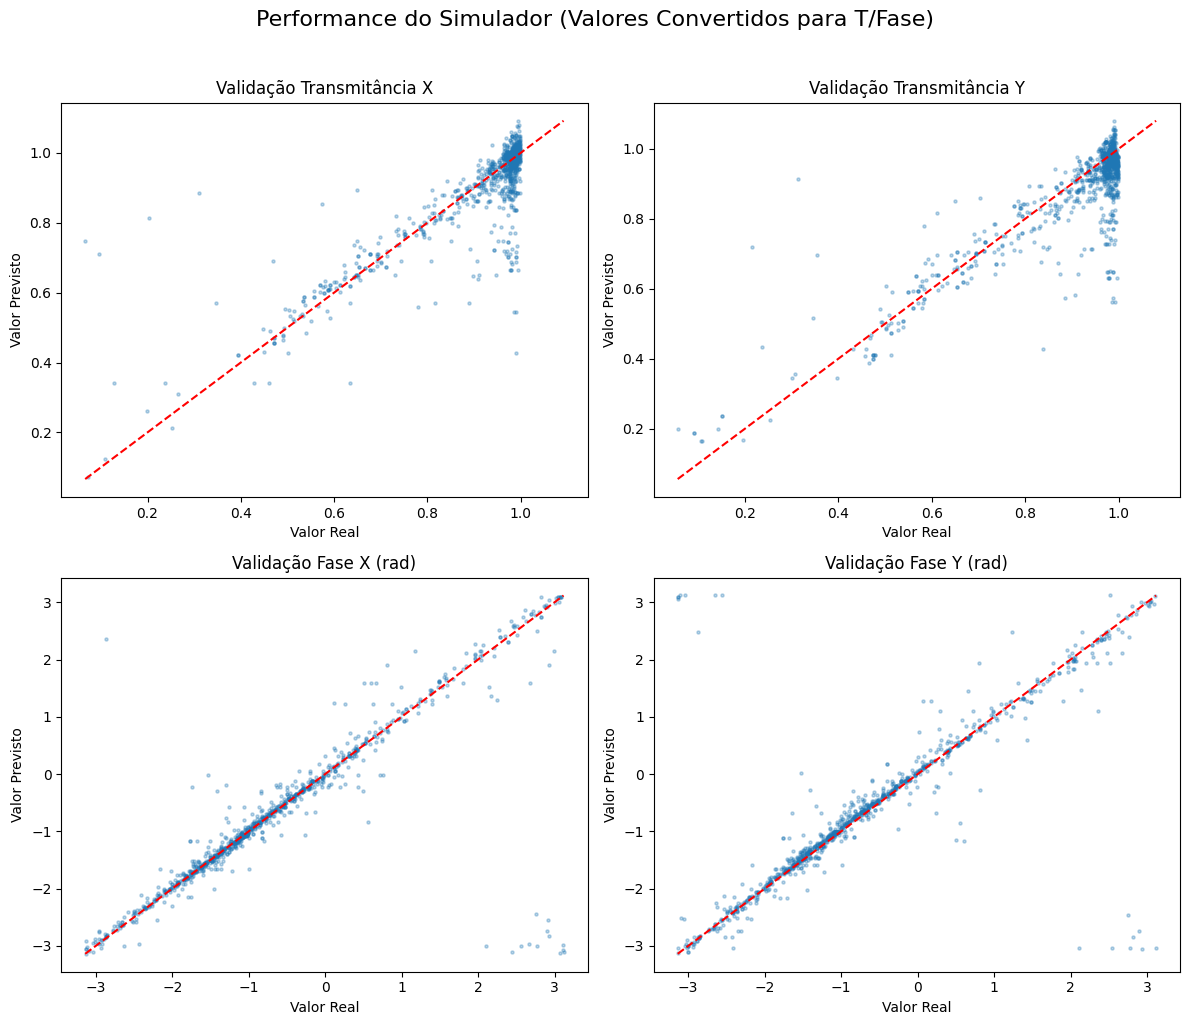


--- Simulação para L_x = 100, L_y = 100, a = 0 ---

Tensor de Saída Bruta (Re/Im): [[-0.36428767 -0.93193275 -0.3316812  -0.901876  ]]
           Resultados da Simulação (Convertidos)           
 L_x: 100.0 nm, L_y: 100.0 nm, a: 0.0 deg
 Transmitancia_x Prevista: 1.0006
 Transmitancia_y Prevista: 0.9609
 Fase_x Prevista: -1.943429 rad
 Fase_y Prevista: -1.923212 rad
 Buscando valores reais no DataFrame para (100.0, 100.0, 0.0)...

AVISO: Uma variável necessária não foi encontrada: name 'df_ellipses' is not defined
Certifique-se de que 'val_loader', 'draw_meta_atom_ellipse' e 'df_ellipses' foram definidos em células anteriores.


In [19]:
# --- Imports necessários para métricas e o modelo ---
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from numpy import sqrt

# --- 1. Definição do Ambiente e Arquitetura ---
# (Necessário para instanciar o modelo antes de carregar os pesos)

# Definir o device (da sua célula de treino)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Definição do Bloco Residual (da sua célula)
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut_path = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut_path = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.main_path(x) + self.shortcut_path(x)
        out = F.relu(out)
        return out

# Definição do Simulador (da sua célula)
N_OUTPUTS = 4
class ResNetSimulator(nn.Module):
    def __init__(self, in_channels=1, n_outputs=N_OUTPUTS):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = ResBlock(64, 64, stride=1)
        self.layer2 = ResBlock(64, 128, stride=2)
        self.layer3 = ResBlock(128, 256, stride=2)
        self.layer4 = ResBlock(256, 256, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.head = nn.Sequential(
            nn.Linear(256 * 2 * 2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.head(out)
        return out

# --- 2. Carregar o Modelo Treinado ---
# (Caminho do seu modelo salvo)
SIMULATOR_PATH = "/content/simulador_NG_teste_1.pth"

# Instanciar a arquitetura
model = ResNetSimulator(in_channels=1, n_outputs=N_OUTPUTS).to(device)

# Carregar os pesos treinados
try:
    model.load_state_dict(torch.load(SIMULATOR_PATH, map_location=device))
    print(f"Modelo carregado com sucesso de {SIMULATOR_PATH}")
except Exception as e:
    print(f"ERRO AO CARREGAR O MODELO: {e}")
    print("Verifique se o caminho do SIMULATOR_PATH está correto.")

# --- 3. Verificação de Precisão (com dados de validação) ---
print("\nIniciando verificação de precisão...")

# Garantir que o modelo esteja em modo de avaliação
model.eval()

all_predictions_raw = []
all_ground_truth_raw = []

# Obter predições brutas (Re/Im) do val_loader
with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        predictions = model(images)
        all_predictions_raw.append(predictions.cpu().numpy())
        all_ground_truth_raw.append(targets.cpu().numpy())

# Concatenar todos os lotes
all_predictions_raw = np.concatenate(all_predictions_raw, axis=0)
all_ground_truth_raw = np.concatenate(all_ground_truth_raw, axis=0)

# Calcular Erro Médio para as 4 saídas (Re/Im)
mae = np.mean(np.abs(all_predictions_raw - all_ground_truth_raw), axis=0)
print(f"\nErro Absoluto Médio (Saídas Brutas Re/Im):")
print(f" S24_real: {mae[0]:.4f}, S24_imag: {mae[1]:.4f}, S13_real: {mae[2]:.6f}, S13_imag: {mae[3]:.6f}")


# Converter Saídas Brutas (Re/Im) para Transmitância/Fase
def convert_to_tf(raw_data):
    s_tm = raw_data[:, 0] + 1j * raw_data[:, 1]
    s_te = raw_data[:, 2] + 1j * raw_data[:, 3]
    t_x = np.abs(s_tm)
    f_x = np.angle(s_tm)
    t_y = np.abs(s_te)
    f_y = np.angle(s_te)
    return np.stack([t_x, t_y, f_x, f_y], axis=1)

all_predictions_tf = convert_to_tf(all_predictions_raw)
all_ground_truth_tf = convert_to_tf(all_ground_truth_raw)


# --- 4. Calcular Métricas de Performance (T/F) ---
print("\n--- Métricas de Performance (Valores Convertidos T/Fase) ---")
labels_tf = ['Transmitancia X', 'Transmitancia Y', 'Fase X (rad)', 'Fase Y (rad)']

for i in range(4):
    y_true = all_ground_truth_tf[:, i]
    y_pred = all_predictions_tf[:, i]

    mae_tf = mean_absolute_error(y_true, y_pred)
    mse_tf = mean_squared_error(y_true, y_pred)
    rmse_tf = sqrt(mse_tf)
    r2_tf = r2_score(y_true, y_pred)

    print(f"\nResultados para: {labels_tf[i]}")
    print(f"  MAE (Erro Absoluto Médio): {mae_tf:.6f}")
    print(f"  RMSE (Raiz do Erro Quad.): {rmse_tf:.6f}")
    print(f"  R² (Coef. de Determinação): {r2_tf:.6f} (ou {r2_tf*100:.2f}%)")

print("\n" + "="*50)


# --- 5. Plotar Gráficos de Dispersão (Agora com T/F corretos) ---
print("Gerando gráficos de dispersão da validação (Convertidos para T/Fase)...")
plt.figure(figsize=(12, 10))
plt.suptitle("Performance do Simulador (Valores Convertidos para T/Fase)", fontsize=16, y=1.02)

plt.subplot(2, 2, 1)
plt.scatter(all_ground_truth_tf[:, 0], all_predictions_tf[:, 0], alpha=0.3, s=5)
lims_tx = [min(all_ground_truth_tf[:, 0].min(), all_predictions_tf[:, 0].min()), max(all_ground_truth_tf[:, 0].max(), all_predictions_tf[:, 0].max())]
plt.plot(lims_tx, lims_tx, 'r--', label='Perfeita')
plt.title("Validação Transmitância X")
plt.xlabel("Valor Real"); plt.ylabel("Valor Previsto")

plt.subplot(2, 2, 2)
plt.scatter(all_ground_truth_tf[:, 1], all_predictions_tf[:, 1], alpha=0.3, s=5)
lims_ty = [min(all_ground_truth_tf[:, 1].min(), all_predictions_tf[:, 1].min()), max(all_ground_truth_tf[:, 1].max(), all_predictions_tf[:, 1].max())]
plt.plot(lims_ty, lims_ty, 'r--', label='Perfeita')
plt.title("Validação Transmitância Y")
plt.xlabel("Valor Real"); plt.ylabel("Valor Previsto")

plt.subplot(2, 2, 3)
plt.scatter(all_ground_truth_tf[:, 2], all_predictions_tf[:, 2], alpha=0.3, s=5)
lims_fx = [min(all_ground_truth_tf[:, 2].min(), all_predictions_tf[:, 2].min()), max(all_ground_truth_tf[:, 2].max(), all_predictions_tf[:, 2].max())]
plt.plot(lims_fx, lims_fx, 'r--', label='Perfeita')
plt.title("Validação Fase X (rad)")
plt.xlabel("Valor Real"); plt.ylabel("Valor Previsto")

plt.subplot(2, 2, 4)
plt.scatter(all_ground_truth_tf[:, 3], all_predictions_tf[:, 3], alpha=0.3, s=5)
lims_fy = [min(all_ground_truth_tf[:, 3].min(), all_predictions_tf[:, 3].min()), max(all_ground_truth_tf[:, 3].max(), all_predictions_tf[:, 3].max())]
plt.plot(lims_fy, lims_fy, 'r--', label='Perfeita')
plt.title("Validação Fase Y (rad)")
plt.xlabel("Valor Real"); plt.ylabel("Valor Previsto")

plt.tight_layout()
plt.show()


# --- 6. Simulação para Novos Valores (Teste de Ponto Único CORRIGIDO) ---
print("\n--- Simulação para L_x = 100, L_y = 100, a = 0 ---")

L_x_new_nm = 100.0
L_y_new_nm = 100.0
a_new_deg = 0.0 # Rotação de 0 graus para este teste

try:
    # 1. Gerar a imagem (use a função de elipse que aceita rotação)
    img_new = draw_meta_atom_ellipse(L_x_new_nm, L_y_new_nm, a_new_deg)

    # 2. Converter para o formato de tensor de batch (1, 1, 64, 64)
    input_tensor = torch.from_numpy(img_new).unsqueeze(0).unsqueeze(0).to(device)

    # 3. Fazer a predição
    with torch.no_grad():
        pred_new_raw = model(input_tensor) # Saída bruta [S24_r, S24_i, S13_r, S13_i]

    # 4. Extrair valores Re/Im
    s24_r = pred_new_raw[0, 0].item()
    s24_i = pred_new_raw[0, 1].item()
    s13_r = pred_new_raw[0, 2].item()
    s13_i = pred_new_raw[0, 3].item()

    # 5. Converter para Transmitância e Fase
    s_tm_pred = s24_r + 1j * s24_i
    s_te_pred = s13_r + 1j * s13_i

    predicted_transmitancia_x = np.abs(s_tm_pred)
    predicted_fase_x = np.angle(s_tm_pred)
    predicted_transmitancia_y = np.abs(s_te_pred)
    predicted_fase_y = np.angle(s_te_pred)

    print(f"\nTensor de Saída Bruta (Re/Im): {pred_new_raw.cpu().numpy()}")
    print("==================================================")
    print("           Resultados da Simulação (Convertidos)           ")
    print("==================================================")
    print(f" L_x: {L_x_new_nm} nm, L_y: {L_y_new_nm} nm, a: {a_new_deg} deg")
    print(f" Transmitancia_x Prevista: {predicted_transmitancia_x:.4f}")
    print(f" Transmitancia_y Prevista: {predicted_transmitancia_y:.4f}")
    print(f" Fase_x Prevista: {predicted_fase_x:.6f} rad")
    print(f" Fase_y Prevista: {predicted_fase_y:.6f} rad")

    # 6. Comparar com o DataFrame original (se o ponto existir)
    print("==================================================")
    print(f" Buscando valores reais no DataFrame para ({L_x_new_nm}, {L_y_new_nm}, {a_new_deg})...")

    # Assumindo que 'df_ellipses' existe na memória
    real_data = df_ellipses[
        (df_ellipses['L_x'] == L_x_new_nm) &
        (df_ellipses['L_y'] == L_y_new_nm) &
        (df_ellipses['a'] == a_new_deg)
    ]

    if not real_data.empty:
        print("           Valores Reais (do DataFrame)           ")
        print("==================================================")
        print(f" Transmitancia_x Real: {real_data['Transmitancia_x'].values[0]:.4f}")
        print(f" Transmitancia_y Real: {real_data['Transmitancia_y'].values[0]:.4f}")
        print(f" Fase_x Real: {real_data['Fase_x'].values[0]:.6f} rad")
        print(f" Fase_y Real: {real_data['Fase_y'].values[0]:.6f} rad")
        print("==================================================")
    else:
        print(f" ...Ponto ({L_x_new_nm}, {L_y_new_nm}, {a_new_deg}) não encontrado no DataFrame.")
        print("==================================================")
except NameError as e:
    print(f"\nAVISO: Uma variável necessária não foi encontrada: {e}")
    print("Certifique-se de que 'val_loader', 'draw_meta_atom_ellipse' e 'df_ellipses' foram definidos em células anteriores.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")